# Plot ORCA12 domain
Based on ORCA0083-N06 domain data from NOCS

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import numpy as np
import gsw
import seawater

In [3]:
from dask.distributed import Client, LocalCluster, wait

In [4]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=48e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46417 instead
  expected, actual


In [5]:
client

Client Scheduler: tcp://127.0.0.1:33851 Dashboard: http://127.0.0.1:46417/status,Cluster Workers: 4 Cores: 8 Memory: 178.81 GiB


## Read data

In [22]:
ddir = '/gxfs_work1/geomar/smomw352/orca0083-n06/'
bathy = '%s/domain/bathymetry_ORCA12_V3.3.nc' % (ddir,)
mask = '%s/domain/mask.nc' % (ddir,)
mesh = '%s/domain/mesh_hgr.nc' % (ddir,)
meshz = '%s/domain/mesh_zgr.nc' % (ddir,)
ds_bathy = xr.open_dataset(bathy)
ds_mask = xr.open_dataset(mask)
ds_mesh = xr.open_dataset(mesh)
ds_meshz = xr.open_dataset(meshz)

In [7]:
ds_bathy

<xarray.Dataset>
Dimensions:     (y: 3059, x: 4322)
Dimensions without coordinates: y, x
Data variables:
    nav_lon     (y, x) float32 ...
    nav_lat     (y, x) float32 ...
    Bathymetry  (y, x) float32 ...
    mask        (y, x) int32 ...
Attributes:
    Title:      Bathymetry ORCA12
    Treatment:  correct bathy
    Comment:    Version V3.2

In [8]:
ds_meshz

<xarray.Dataset>
Dimensions:       (y: 3059, x: 4322, z: 75, t: 1)
Dimensions without coordinates: y, x, z, t
Data variables: (12/17)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    mbathy        (t, y, x) int16 ...
    e3t_0         (t, z, y, x) float64 ...
    ...            ...
    gdepv         (t, z, y, x) float32 ...
    gdepw_0       (t, z, y, x) float32 ...
    gdept_1d      (t, z) float64 ...
    gdepw_1d      (t, z) float64 ...
    e3t_1d        (t, z) float64 ...
    e3w_1d        (t, z) float64 ...
Attributes:
    DOMAIN_number_total:  8972
    DOMAIN_size_global:   [4322 3059]

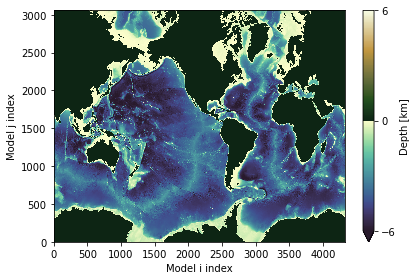

In [8]:
fig, ax = plt.subplots(1,1)
levels = np.linspace(-6,6,100)
cbar_kwargs={"ticks": [-6,0,6],'label':'Depth [km]'}
#(-ds_bathy['Bathymetry']/1e3).plot.contourf(ax=ax,levels=levels,extend='both',cmap=cmocean.cm.topo,rasterized=True,cbar_kwargs=cbar_kwargs)
(-ds_bathy['Bathymetry']/1e3).plot.pcolormesh(ax=ax,vmin=-6,vmax=6,cmap=cmocean.cm.topo,rasterized=True,cbar_kwargs=cbar_kwargs)
ax.set_xlabel('Model i index')
ax.set_ylabel('Model j index')
fig.tight_layout()
fig.savefig('bathymetry.pdf',format='pdf',dpi=300)

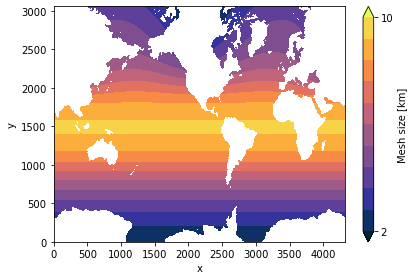

In [11]:
et_m = 0.5 * (ds_mesh['e1t'][0,:,:] + ds_mesh['e2t'][0,:,:]).where(ds_bathy['Bathymetry'] > 0)
fig, ax = plt.subplots(1,1)
levels = np.linspace(2,10,11)
cbar_kwargs={"ticks": [2,10],'label':'Mesh size [km]'}
#(et_m/1e3).plot.pcolormesh(ax=ax,vmin=0,vmax=10,extend='max',cmap=cmocean.cm.thermal,rasterized=True,cbar_kwargs=cbar_kwargs)
(et_m/1e3).plot.contourf(ax=ax,levels=levels,extend='both',cmap=cmocean.cm.thermal,rasterized=True,cbar_kwargs=cbar_kwargs)
fig.tight_layout()
#fig.savefig('mesh_mean.pdf',format='pdf')

## Compute Rossby radius

In [9]:
def rossby_rad(salt, temp, z1d, lons, lats, e3t1d):
    # Construct 3d depth
    _ones = 1 + lats * 0
    dep3d = z1d * _ones
    
    # Get pressure
    p1d = seawater.eos80.pres(dep3d, lats)
    
    # Get abs salinity
    #SA = gsw.SA_from_SP(salt, p, lons, lats)
    # Get conservative temperature
    #CT = gsw.conversions.CT_from_pt(SA, temp)
    
    # BV frequency
    #N2, p_mid = gsw.stability.Nsquared(SA, CT, p)
    n2,q,p_ave = seawater.geostrophic.bfrq(salt, temp, p1d)
    
    # Make BV DataArray
    ds_n = xr.Dataset(
    data_vars=dict(
        N2=(["z", "y", "x"], n2[:,:,:]),
        q=(["z", "y", "x"], q[:,:,:]),
    ),
    coords=dict(
        nav_lon=(["y", "x"], lons.data),
        nav_lat=(["y", "x"], lats.data),
        deptht=(["z"], 0.5*(z1d.data[0:-1] + z1d.data[1:])),
    ),
    )
    
    # N is sqrt(N2)
    n = ds_n['N2']**0.5
    
    # dz in mid layer
    dz_m = 0.5 * (e3t1d[0:-1] + e3t1d[1:])
    
    # Integrate vertical
    # Eigenvalue problem (Chelton et al. JPO, 1998, eq 2.2)
    ndz = n * dz_m
    nz  = ndz.sum('z')
    nz.name = 'nz'
    ds_nz = nz.to_dataset()
    
    # First baroclinic wave phase speed
    m = 1
    c1  = 1.0/(m*np.pi) * nz
    
    c1.name = 'c1'
    ds_c = c1.to_dataset()
    
    # Coriolis parameter
    omega = 2.0 * np.pi / 86400 # rotation rate of Earth
    radius = 6371e3 # radius of Earth
    f = 2.0 * omega * np.sin( lats * np.pi/180.0 )
    
    # Beta
    beta = 2.0 * omega * np.cos( lats * np.pi/180.0 ) / radius
    
    # Rossby radius
    ross_midl = c1 / np.abs(f)            # Chelton et al. 2002, eq 2.3a
    ross_trop = (c1 / (2.0 * beta))**0.5  # Chelton et al. 2002, eq 2.3b
    print(ross_trop)
    ross_midl.name = 'ross_mid'
    ross_trop.name = 'ross_trop'
    ds_rm = ross_midl.to_dataset()
    ds_rt = ross_trop.to_dataset()
    
    # Combine to one field
    ross = np.where( np.abs(lats) >= 5.0, ross_midl, ross_trop )
    
    ds_r = xr.Dataset(
    data_vars=dict(
        rd=(["y", "x"], ross),
    ),
    coords=dict(
        nav_lon=(["y", "x"], lons.data),
        nav_lat=(["y", "x"], lats.data),
    ),
    )
    
    return xr.merge([ds_r, ds_rm, ds_rt, ds_c, ds_n, ds_nz]) 

In [10]:
tfile = '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo/FOCI_BJK019_5d_19591201_19591231_grid_T.nc'
ds_t = xr.open_mfdataset(tfile,combine='by_coords').rename({'deptht':'z'})

In [11]:
# Compute Rossby radius for ORCA12
ds_r = rossby_rad(ds_t['soce'][0,:,:,:], 
                ds_t['toce'][0,:,:,:], 
                ds_meshz['gdept_1d'][0,:], 
                ds_mesh['glamt'][0,:,:],
                ds_mesh['gphit'][0,:,:], 
                ds_meshz['e3t_0'][0,:,:,:])

<xarray.DataArray (y: 3059, x: 4322)>
array([[ 0.,  0.,  0., ...,  0., nan, nan],
       [ 0.,  0.,  0., ...,  0., nan, nan],
       [ 0.,  0.,  0., ...,  0., nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0., nan, nan],
       [ 0.,  0.,  0., ...,  0., nan, nan],
       [ 0.,  0.,  0., ...,  0., nan, nan]])
Coordinates:
    nav_lon  (y, x) float32 72.92 73.0 73.08 73.17 73.25 ... 73.0 73.0 nan nan
    nav_lat  (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.0 50.0 nan nan
Dimensions without coordinates: y, x


In [13]:
ds_r

<xarray.Dataset>
Dimensions:    (y: 3059, x: 4322, z: 74)
Coordinates:
    nav_lon    (y, x) float32 72.92 73.0 73.08 73.17 73.25 ... 73.0 73.0 nan nan
    nav_lat    (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.0 50.0 nan nan
    deptht     (z) float64 1.031 2.112 3.262 ... 5.393e+03 5.596e+03 5.8e+03
Dimensions without coordinates: y, x, z
Data variables:
    rd         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan nan
    ross_mid   (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan nan
    ross_trop  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan nan
    c1         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    N2         (z, y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    q          (z, y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    nz         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Repeat for ORCA05

In [14]:
ddir = '/gxfs_work1/geomar/smomw352/'
mesh = '%s/orca05_mesh_mask.nc' % (ddir,)
ds_mesh05 = xr.open_dataset(mesh)

In [15]:
tfile2 = '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK012/outdata/nemo/FOCI_GJK012_5d_19500101_19591231_grid_T.nc'
ds_t_05 = xr.open_mfdataset(tfile2,combine='by_coords').rename({'deptht':'z'})

In [16]:
ds_r_05 = rossby_rad(ds_t_05['soce'][0,:,:,:], 
                ds_t_05['toce'][0,:,:,:], 
                ds_mesh05['gdept_0'][0,:], 
                ds_mesh05['glamt'][0,:,:],
                ds_mesh05['gphit'][0,:,:], 
                ds_mesh05['e3t'][0,:,:,:])

<xarray.DataArray (y: 511, x: 722)>
array([[161111.49845641, 161111.49845641, 161111.49845641, ...,
        161111.49845641, 161111.49845641, 161111.49845641],
       [160427.68944954, 160427.68944954, 160427.68944954, ...,
        160427.68944954, 160427.68944954, 160427.68944954],
       [159746.90796376, 159746.90796376, 159746.90796376, ...,
        159746.90796376, 159746.90796376, 159746.90796376],
       ...,
       [ 95135.81626113,  95135.81626113,  95212.14222776, ...,
         95212.14222776,  95135.81626113,  95135.81626113],
       [ 95143.13272006,  95143.13272006,  95213.35873262, ...,
         95213.35873262,  95143.13272006,  95143.13272006],
       [ 95143.13272006,  95143.13272006,  95213.35873262, ...,
         95213.35873262,  95143.13272006,  95143.13272006]])
Coordinates:
    nav_lon  (y, x) float32 72.75 73.25 73.75 74.25 ... 73.02 73.01 73.0 73.0
    nav_lat  (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.07 50.0 50.0
Dimensions without coordinates: y, x


## Save

In [17]:
ds_r.to_netcdf('rossby_radius_orca12.nc')
ds_r_05.to_netcdf('rossby_radius_orca05.nc')

## Plot Rossby radii

Text(0.5, 1.0, 'FOCI-OpenIFS-LR')

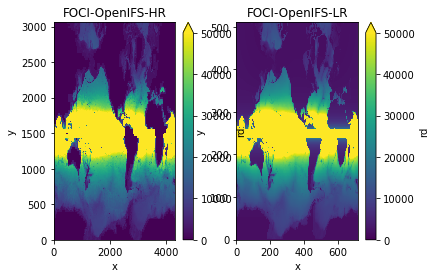

In [19]:
fig1, ax1 = plt.subplots(1,2)
ds_r['rd'].plot(ax=ax1[0],vmin=0,vmax=50e3)
ds_r_05['rd'].plot(ax=ax1[1],vmin=0,vmax=50e3)
ax1[0].set_title('FOCI-OpenIFS-HR')
ax1[1].set_title('FOCI-OpenIFS-LR')

In [24]:
# Grid size 
et_m = 0.5 * (ds_mesh['e1t'][0,:,:] + ds_mesh['e2t'][0,:,:])
# Hallberg says dx*2
minres = et_m * 2

et_m_05 = 0.5 * (ds_mesh05['e1t'][0,:,:] + ds_mesh05['e2t'][0,:,:])
minres05 = et_m_05 * 2

# Rossby radius / res
frac = (ds_r['rd'] / minres).where(ds_mask['tmask'][0,0,:,:] > 0)
frac_05 = (ds_r_05['rd'] / minres05).where(ds_mesh05['tmask'][0,0,:,:] > 0)

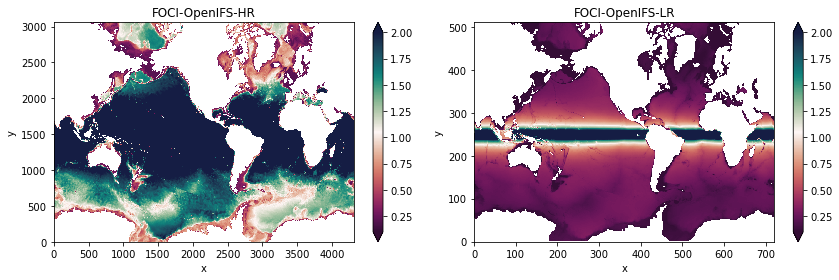

In [32]:
fig1, ax1 = plt.subplots(1,2,figsize=(12,4))
frac.plot(ax=ax1[0],vmin=0.1,vmax=2,cmap=cmocean.cm.curl_r,extend='both',rasterized=True)
frac_05.plot(ax=ax1[1],vmin=0.1,vmax=2,cmap=cmocean.cm.curl_r,extend='both',rasterized=True)
ax1[0].set_title('FOCI-OpenIFS-HR')
ax1[1].set_title('FOCI-OpenIFS-LR')
fig1.tight_layout()
fig1.savefig('figures/ross_2dx.pdf',format='pdf',dpi=150)

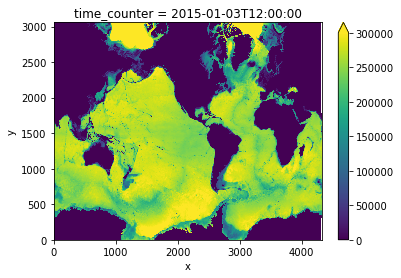

In [48]:
ross_trop.plot(vmin=0,vmax=300e3)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [53]:
dep1 = ds_meshz['gdept_1d'][0,:]
print(ross)
ds_r = xr.Dataset(
    data_vars=dict(
        rr=(["time_counter", "y", "x"], ross),
    ),
    coords=dict(
        nav_lon=(["y", "x"], lon),
        nav_lat=(["y", "x"], lat),
        time_counter=(["time_counter"], ds_t["time_counter"]),
    ),
)
ds_r.to_netcdf('rr.nc')

[[[ 0.  0.  0. ...  0. nan nan]
  [ 0.  0.  0. ...  0. nan nan]
  [ 0.  0.  0. ...  0. nan nan]
  ...
  [ 0.  0.  0. ...  0. nan nan]
  [ 0.  0.  0. ...  0. nan nan]
  [ 0.  0.  0. ...  0. nan nan]]]


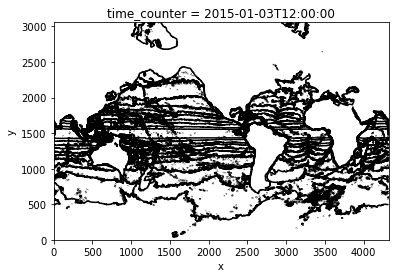

In [61]:
levels = np.array([10,20,30,40,50,60,80,100,150,230]) * 1e3
fig,ax = plt.subplots(1,1)
#ds_r['rr'][0,:,:].plot.pcolormesh(ax=ax,vmin=0,vmax=300e3,cmap=cmocean.cm.thermal)
ds_r['rr'][0,:,:].plot.contour(ax=ax,levels=levels,colors='k')

## Plot Hallberg 2013 plot

In [82]:
rr = xr.open_dataset('rr.nc')
ross = rr['rr'][0,:,:].fillna(0)

<xarray.DataArray 'rr' (y: 3059, x: 4322)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    time_counter  datetime64[ns] 2015-01-03T12:00:00
Dimensions without coordinates: y, x


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)


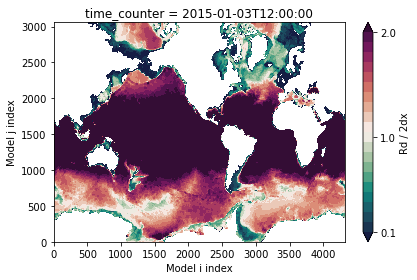

In [101]:
et_m = 0.5 * (ds_mesh['e1t'][0,:,:] + ds_mesh['e2t'][0,:,:])
minres = et_m * 2

rr = ross.where(ross > 0)
frac = rr / minres

fig, ax = plt.subplots(1,1)
levels = np.linspace(0.1,2.,21)
cbar_kwargs={"ticks": [0.1,1,2.0],'label':'Rd / 2dx'}
frac.plot.contourf(ax=ax,levels=levels,extend='both',cmap=cmocean.cm.curl,rasterized=True,cbar_kwargs=cbar_kwargs)
ax.set_xlabel('Model i index')
ax.set_ylabel('Model j index')
#ax.set_title('1st bc Rossby radius / 2 * grid size')
fig.tight_layout()
fig.savefig('rd_mesh.pdf',format='pdf',dpi=300)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)


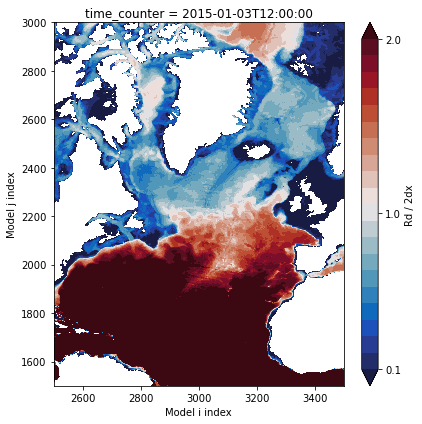

In [103]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
levels = np.linspace(0.1,2.,21)
cbar_kwargs={"ticks": [0.1,1,2.0],'label':'Rd / 2dx'}
frac.plot.contourf(ax=ax,levels=levels,extend='both',cmap=cmocean.cm.balance,rasterized=True,cbar_kwargs=cbar_kwargs)
ax.set_xlabel('Model i index')
ax.set_ylabel('Model j index')
ax.set_xlim([2500,3500])
ax.set_ylim([1500,3000])
#ax.set_title('1st bc Rossby radius / 2 * grid size')
fig.tight_layout()
fig.savefig('rd_mesh_zoom.pdf',format='pdf',dpi=300)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)


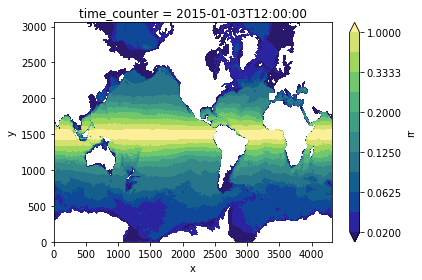

In [107]:
et_m = 0.5 * (ds_mesh['e1t'][0,:,:] + ds_mesh['e2t'][0,:,:])
minres = et_m * 2

rr = ross.where(ross > 0)

# Rossby radius in degrees
rr_deg = rr / 6371e3 * 180.0 / np.pi

# Resolution needed to resolve by two cells
rr_lim = rr_deg / 2.0

fig, ax = plt.subplots(1,1)
levels = np.array([1./50, 1./25, 1./16, 1./12, 1./8, 1./6, 1./5, 1./4, 1./3, 1./2, 1.])
#cbar_kwargs={"ticks": [0.1,1,2.0],'label':'Rd / 2dx'}
rr_lim.plot.contourf(ax=ax,levels=levels,extend='both',cmap=cmocean.cm.haline,rasterized=True) #,cbar_kwargs=cbar_kwargs)
#ax.set_title('1st bc Rossby radius / 2 * grid size')
fig.tight_layout()
#fig.savefig('rd_mesh.pdf',format='pdf',dpi=300)